In [1]:
from __future__ import print_function

import numpy as np
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy
import scipy.optimize
import scipy.io

from itertools import izip

plt.style.use('classic')
mpl.rcParams['axes.xmargin'] = 0.0
mpl.rcParams['axes.ymargin'] = 0.0

%matplotlib inline

In [2]:
data = scipy.io.loadmat ('ex5data1.mat')

X = data['X']
y = data['y']

m = X.shape[0]
X = np.hstack ((np.ones ((m, 1)), X))

X_val = data['Xval']
y_val = data['yval']

m_val = X_val.shape[0]
X_val = np.hstack ((np.ones ((m_val, 1)), X_val))

X_test = data['Xtest']
y_test = data['ytest']

m_test = X_test.shape[0]
X_test = np.hstack ((np.ones ((m_test, 1)), X_test))

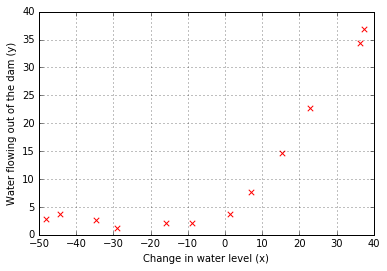

In [3]:
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.scatter (X[:, 1], y, marker='x', color='r', s=30)
ax.set_xlabel ('Change in water level (x)')
ax.set_ylabel ('Water flowing out of the dam (y)')
ax.set_xlim (-50, 40)
ax.set_ylim (0, 40)
ax.grid ()

In [4]:
def linearRegCostFunction (X, y, theta, lambda_reg):
    m = len (y)
    n = X.shape[1]
    theta = theta.reshape ((n, 1))
    
    h_theta = X.dot (theta)
    J = 1. / (2. * m) * (np.sum ((h_theta - y)**2)) + \
        lambda_reg / (2. * m) * np.sum (theta[1:]**2)
        
    return (J)

def linearRegCostFunctionGradient (X, y, theta, lambda_reg):
    m = len (y)
    n = X.shape[1]
    theta = theta.reshape ((n, 1))
    
    h_theta = X.dot (theta)
    grad = 1. / m * X.T.dot (h_theta - y)
    grad[1:] += lambda_reg / m * theta[1:]
    return (grad.flatten  ())

In [5]:
theta = np.array ([1., 1.])

J = linearRegCostFunction (X, y, theta, 1.)
print ('Cost at theta = [1 ; 1]: {0:.6f}'.format (J))
print ('(this value should be about 303.993192)')

Cost at theta = [1 ; 1]: 303.993192
(this value should be about 303.993192)


In [6]:
grad = linearRegCostFunctionGradient (X, y, theta, 1.)
print ('Gradient at theta = [1 ; 1]:  {}'.format (grad))
print ('(this value should be about [-15.303016; 598.250744])')

Gradient at theta = [1 ; 1]:  [ -15.30301567  598.25074417]
(this value should be about [-15.303016; 598.250744])


In [25]:
def trainLinearReg (X, y, lambda_reg, disp=False):
    initial_theta = np.zeros (X.shape[1])
    costFunc = lambda theta, X=X, y=y, lambda_reg=lambda_reg: \
        linearRegCostFunction (X, y, theta, lambda_reg)
    costGrad = lambda theta, X=X, y=y, lambda_reg=lambda_reg: \
        linearRegCostFunctionGradient (X, y, theta, lambda_reg)
    result = scipy.optimize.minimize (
        fun=costFunc, x0=initial_theta, jac=costGrad, method='CG',
        options=dict (maxiter=50, disp=disp))
    return (result)

In [26]:
lambda_reg = 0
result = trainLinearReg (X, y, lambda_reg, disp=True)
theta = result.x

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5


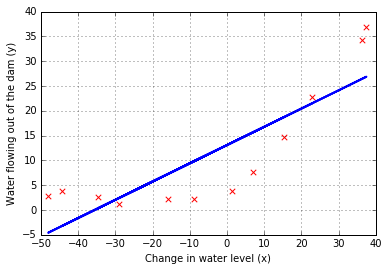

In [27]:
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.scatter (X[:, 1], y, marker='x', color='r', s=30)
ax.plot (X[:, 1], X.dot (theta.reshape ((X.shape[1], 1))), 
         color='b', ls='-', lw=2)
ax.set_xlabel ('Change in water level (x)')
ax.set_ylabel ('Water flowing out of the dam (y)')
ax.set_xlim (-50, 40)
ax.set_ylim (-5, 40)
ax.grid ()

In [10]:
def learningCurve (X, y, X_val, y_val, lambda_reg):
    m = X.shape[0]
    m_val = X_val.shape[0]
    
    error_train = np.zeros (m)
    error_val = np.zeros (m)
    
    for i in range (m):
        X_train = X[:i+1]
        y_train = y[:i+1]
        
        result = trainLinearReg (X_train, y_train, lambda_reg)
        theta = result.x
        
        error_train[i] = linearRegCostFunction (X_train, y_train, theta, 0.)
        error_val[i] = linearRegCostFunction (X_val, y_val, theta, 0.)
        
    return (error_train, error_val)

In [11]:
lambda_reg = 0.
error_train, error_val = learningCurve (X, y, X_val, y_val, lambda_reg)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 3
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 3.286595
         Iterations: 9
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 2.842678
         Iterations: 8
         Function evaluations: 14
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: 13.154049
         Iterations: 22
         Function evaluations: 34
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: 19.443963
         Iterations: 22
         Function evaluations: 34
        

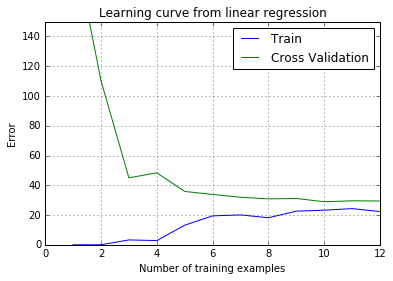

In [12]:
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.plot (np.arange (1, m+1), error_train, label='Train')
ax.plot (np.arange (1, m+1), error_val, label='Cross Validation')
ax.set_xlabel ('Number of training examples')
ax.set_ylabel ('Error')
ax.set_title ('Learning curve from linear regression')
ax.set_ylim (0, 150)
ax.grid ()
ax.legend (loc='upper right')

In [13]:
def featureNormalize (X):
    X_norm = X.copy ()
    mu = np.mean (X, axis=0)
    sigma = np.std (X, axis=0, ddof=1)
    X_norm = (X_norm - mu) / sigma
        
    return (X_norm, mu, sigma)

def polyFeatures (X, p):
    X_poly = np.zeros ((X.shape[0], p))
    
    for i in range (p):
        X_poly[:, [i]] = X**(i+1)
        
    return (X_poly)

In [14]:
p=8
X_poly = polyFeatures (X[:, [1]], p)
X_poly, mu, sigma = featureNormalize (X_poly)
X_poly = np.hstack ((np.ones ((m, 1)), X_poly))

X_poly_test = polyFeatures (X_test[:, [1]], p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.hstack ((np.ones ((m_test, 1)), X_poly_test))

X_poly_val = polyFeatures (X_val[:, [1]], p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.hstack ((np.ones ((m_val, 1)), X_poly_val))

np.set_printoptions (precision=6)
print ('Normalized Training Example 1:')
print (X_poly[[0]].T)

Normalized Training Example 1:
[[ 1.      ]
 [-0.362141]
 [-0.755087]
 [ 0.182226]
 [-0.70619 ]
 [ 0.306618]
 [-0.590878]
 [ 0.344516]
 [-0.508481]]


In [15]:
lambda_reg = 0.
result = trainLinearReg (X_poly, y, lambda_reg)

         Current function value: 0.213377
         Iterations: 50
         Function evaluations: 89
         Gradient evaluations: 89


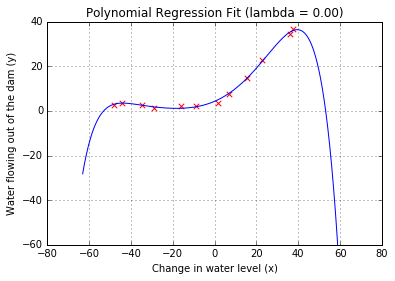

In [16]:
X_dens = np.arange (X[:, 1].min () - 15., X[:, 1].max () + 25, 0.05)
X_dens_poly = polyFeatures (X_dens.reshape (-1, 1), p)
X_dens_poly -= mu
X_dens_poly /= sigma
X_dens_poly = np.hstack ((np.ones ((X_dens_poly.shape[0], 1)), X_dens_poly))
theta = result.x.reshape((-1, 1))

fig = plt.figure ()
ax = fig.add_subplot (111)
ax.scatter (X[:, 1], y, marker='x', color='r', s=30)
ax.plot (X_dens, X_dens_poly.dot (theta).T[0])
ax.set_xlabel ('Change in water level (x)')
ax.set_ylabel ('Water flowing out of the dam (y)')
ax.set_title ('Polynomial Regression Fit (lambda = {0:.2f})'.format (lambda_reg))
ax.set_xlim (-80, 80)
ax.set_ylim (-60, 40)
ax.grid ()

In [17]:
lambda_reg = 0.
error_train, error_val = learningCurve (X_poly, y, X_poly_val, y_val, lambda_reg)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 18
         Gradient evaluations: 18
         Current function value: 0.000289
         Iterations: 50
         Function evaluations: 92
         Gradient evaluations: 92
         Current function value: 0.000004
         Iterations: 50
         Function evaluations: 102
         Gradient evaluations: 102
         Current function value: 0.050254
       

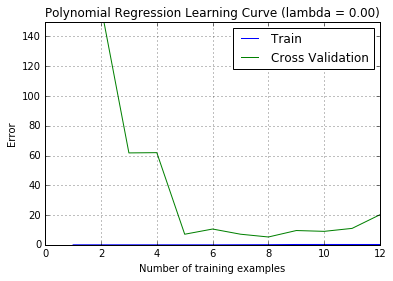

In [18]:
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.plot (np.arange (1, m+1), error_train, label='Train')
ax.plot (np.arange (1, m+1), error_val, label='Cross Validation')
ax.set_xlabel ('Number of training examples')
ax.set_ylabel ('Error')
ax.set_ylim (0, 150)
ax.grid ()
ax.set_title ('Polynomial Regression Learning Curve (lambda = {0:.2f})'.format (lambda_reg))
ax.legend (loc='upper right')

In [20]:
def validationCurve (X, y, X_val, y_val):
    lambda_vec = np.array ([0., 0.001, 0.003, 0.01, 0.03, 
                            0.1,  0.3, 1., 3., 10.])
    d = len (lambda_vec)
    m = X.shape[0]
    m_val = X_val.shape[0]
    
    error_train = np.zeros (d)
    error_val = np.zeros (d)
    
    for i in range (d):
        result = trainLinearReg (X, y, lambda_vec[i])
        theta = result.x
        
        error_train[i] = linearRegCostFunction (X, y, theta, 0.)
        error_val[i] = linearRegCostFunction (X_val, y_val, theta, 0.)
        
    return (lambda_vec, error_train, error_val)

In [22]:
lambda_vec, error_train, error_val = \
    validationCurve (X_poly, y, X_poly_val, y_val)

         Current function value: 0.213377
         Iterations: 50
         Function evaluations: 89
         Gradient evaluations: 89
         Current function value: 0.240102
         Iterations: 50
         Function evaluations: 94
         Gradient evaluations: 94
         Current function value: 0.256927
         Iterations: 50
         Function evaluations: 99
         Gradient evaluations: 99
         Current function value: 0.392529
         Iterations: 50
         Function evaluations: 96
         Gradient evaluations: 96
         Current function value: 0.669585
         Iterations: 50
         Function evaluations: 95
         Gradient evaluations: 95
Optimization terminated successfully.
         Current function value: 1.443470
         Iterations: 49
         Function evaluations: 99
         Gradient evaluations: 99
         Current function value: 3.101591
         Iterations: 50
         Function evaluations: 91
         Gradient evaluations: 91
Optimization terminated 

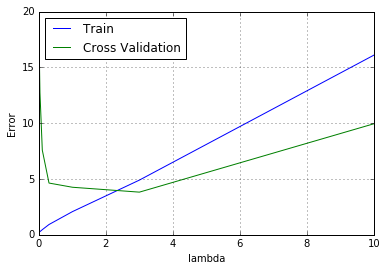

In [24]:
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.plot (lambda_vec, error_train, label='Train')
ax.plot (lambda_vec, error_val, label='Cross Validation')
ax.set_xlabel ('lambda')
ax.set_ylabel ('Error')
ax.set_ylim (0, 20)
ax.legend (loc='upper left')
ax.grid ()

In [43]:
def learningCurveAvg (X, y, X_val, y_val, lambda_reg):
    m = X.shape[0]
    m_val = X_val.shape[0]
    
    iters = 200
    
    error_train = np.zeros (m)
    error_val = np.zeros (m)
    
    for i in range (m):
        error_train_temp = np.zeros (iters)
        error_val_temp = np.zeros (iters)
        for j in range (iters):
            sel = np.random.choice (np.arange (m), i+1)
            sel_val = np.random.choice (np.arange (m_val), i+1)
            
            X_train = X[sel]
            y_train = y[sel]
            
            X_val_temp = X_val[sel_val]
            y_val_temp = y_val[sel_val]

            result = trainLinearReg (X_train, y_train, lambda_reg)
            theta = result.x

            error_train_temp[j] = linearRegCostFunction (X_train, y_train, theta, 0.)
            error_val_temp[j] = linearRegCostFunction (X_val_temp, y_val_temp, theta, 0.)
            
        error_train[i] = np.mean (error_train_temp)
        error_val[i] = np.mean (error_val_temp)
        
    return (error_train, error_val)

In [44]:
lambda_reg = 0.01 
error_train, error_val = learningCurveAvg (X_poly, y, X_poly_val, y_val, lambda_reg)

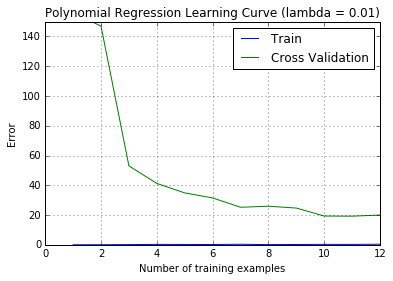

In [45]:
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.plot (np.arange (1, m+1), error_train, label='Train')
ax.plot (np.arange (1, m+1), error_val, label='Cross Validation')
ax.set_xlabel ('Number of training examples')
ax.set_ylabel ('Error')
ax.set_ylim (0, 150)
ax.grid ()
ax.set_title ('Polynomial Regression Learning Curve (lambda = {0:.2f})'.format (lambda_reg))
ax.legend (loc='upper right')